Please upload the Spanish cities CSV file.


Saving spain_cities.csv to spain_cities (3).csv
Dataset preview:
        city      lat     lng country iso2 iso3  population          id
0     Madrid  40.4169 -3.7033   Spain   ES  ESP     6211000  1724616994
1  Barcelona  41.3828  2.1769   Spain   ES  ESP     4800000  1724594040
2   Valencia  39.4700 -0.3764   Spain   ES  ESP     1595000  1724981666
3    Sevilla  37.3900 -5.9900   Spain   ES  ESP     1100000  1724991838
4     Malaga  36.7194 -4.4200   Spain   ES  ESP      967250  1724397372
Total cities: 765
Building graph...
Running BFS...
Running Greedy BFS...
Running A* with Haversine...
Running A* with Euclidean...

Results:
BFS: Time = 0.003s, Distance = 760.56 km, Path = ['Madrid', 'Leganes', 'Pinto', 'San Martin de la Vega', 'Aranjuez', 'Ocana', 'Villacanas', 'Quintanar de la Orden', 'Socuellamos', 'La Roda', 'Cuenca', 'Teruel', 'Alcora', 'Benicasim', 'Benicarlo', 'Alcanar', 'Cambrils', 'Cunit', 'Castelldefels', 'El Prat de Llobregat', 'Barcelona']
Greedy BFS: Time = 0.002s, Di

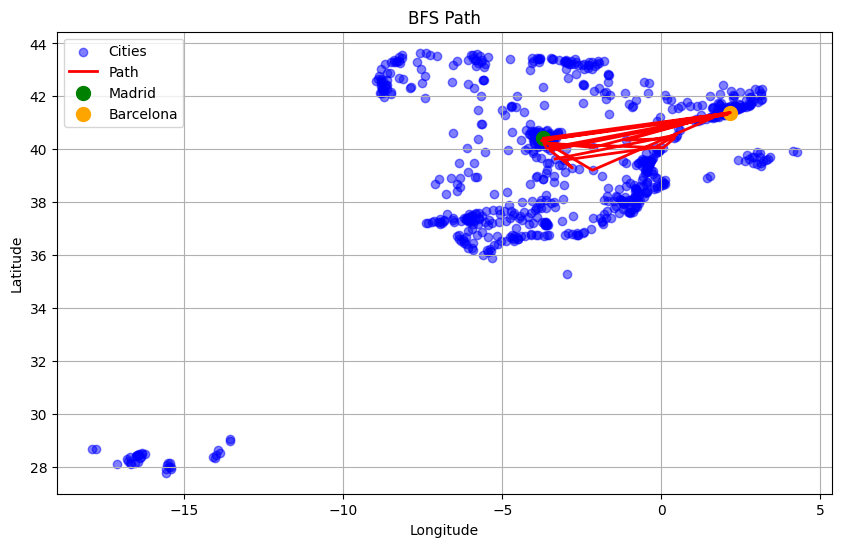

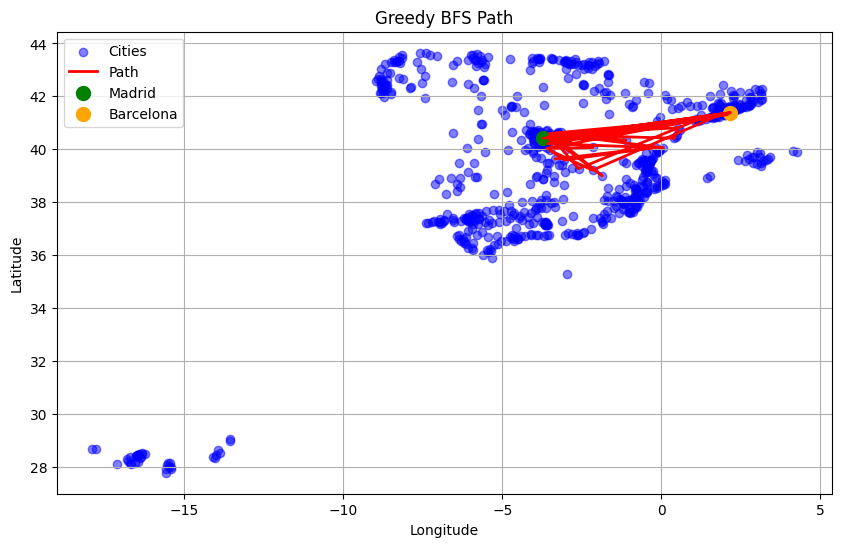

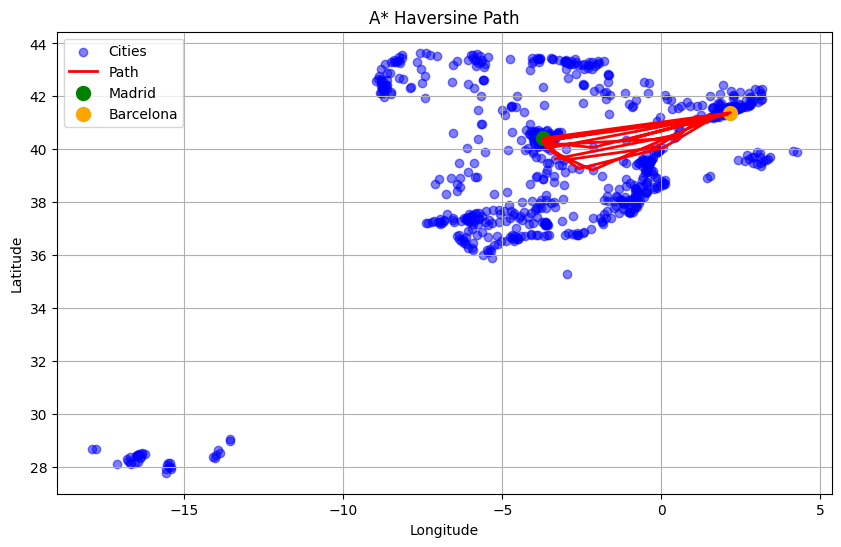

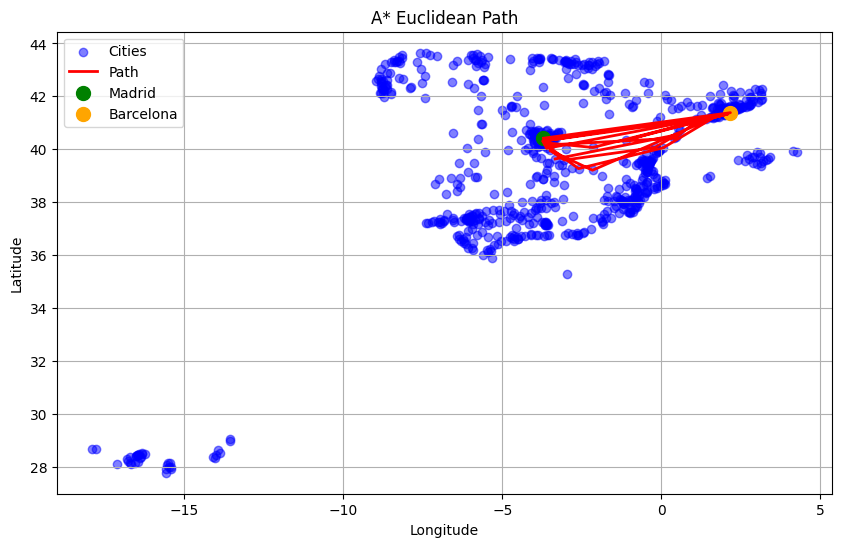

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import heapq
import time
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload the dataset
print("Please upload the Spanish cities CSV file.")
uploaded = files.upload()
data = pd.read_csv(list(uploaded.keys())[0])  # Load the CSV (columns: city, lat, lng)

# Step 2: Verify the dataset
print("Dataset preview:")
print(data.head())
print("Total cities:", len(data))

# Step 3: Haversine distance function (distance between two points on a sphere in km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Step 4: Custom heuristic: Euclidean distance (admissible but less accurate for a sphere)
def euclidean_heuristic(lat1, lon1, lat2, lon2):
    # Approximate flat-plane distance (simplified, admissible)
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    x = (lon2 - lon1) * cos((lat1 + lat2) / 2)
    y = (lat2 - lat1)
    return R * sqrt(x**2 + y**2)

# Step 5: Build the graph: each city connected to its 10 nearest neighbors
def build_graph(df):
    graph = {}
    for i, city1 in df.iterrows():
        distances = []
        for j, city2 in df.iterrows():
            if i != j:
                dist = haversine(city1['lat'], city1['lng'], city2['lat'], city2['lng'])
                distances.append((city2['city'], dist, city2['lat'], city2['lng']))
        # Sort by distance and take 10 nearest neighbors
        distances.sort(key=lambda x: x[1])
        graph[city1['city']] = distances[:10]  # (city_name, distance, lat, lon)
    return graph

# Step 6: Breadth-First Search (uninformed)
def bfs(graph, start, goal):
    queue = [(start, [start])]
    visited = set()
    while queue:
        (node, path) = queue.pop(0)
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor, _, _, _ in graph[node]:
                if neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))
    return None

# Step 7: Greedy Best-First Search (informed, Haversine heuristic)
def greedy_bfs(graph, start, goal, goal_lat, goal_lon):
    queue = [(haversine(start[1], start[2], goal_lat, goal_lon), start[0], [start[0]])]
    visited = set()
    heapq.heapify(queue)
    while queue:
        _, node, path = heapq.heappop(queue)
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor, _, lat, lon in graph[node]:
                if neighbor not in visited:
                    h = haversine(lat, lon, goal_lat, goal_lon)
                    heapq.heappush(queue, (h, neighbor, path + [neighbor]))
    return None

# Step 8: A* Search (informed, with customizable heuristic)
def a_star(graph, start, goal, goal_lat, goal_lon, heuristic_func):
    queue = [(0, start[0], [start[0]], 0)]  # (f = g + h, node, path, g)
    visited = set()
    g_scores = {start[0]: 0}
    heapq.heapify(queue)
    while queue:
        f, node, path, g = heapq.heappop(queue)
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor, dist, lat, lon in graph[node]:
                new_g = g + dist
                if neighbor not in g_scores or new_g < g_scores[neighbor]:
                    g_scores[neighbor] = new_g
                    h = heuristic_func(lat, lon, goal_lat, goal_lon)
                    f = new_g + h
                    heapq.heappush(queue, (f, neighbor, path + [neighbor], new_g))
    return None

# Step 9: Calculate total path distance
def calculate_path_distance(graph, path):
    if not path:
        return float('inf')
    total_dist = 0
    for i in range(len(path) - 1):
        for neighbor, dist, _, _ in graph[path[i]]:
            if neighbor == path[i + 1]:
                total_dist += dist
                break
    return total_dist

# Step 10: Main execution
print("Building graph...")
graph = build_graph(data)

# Find Madrid and Barcelona
try:
    madrid = data[data['city'] == 'Madrid'].iloc[0]
    valencia = data[data['city'] == 'Barcelona'].iloc[0]
except IndexError:
    print("Error: Madrid or Barcelona not found in the dataset. Please check the city names.")
    raise

start = (madrid['city'], madrid['lat'], madrid['lng'])
goal = (barcelona['city'], barcelona['lat'], barcelona['lng'])

# Run BFS
print("Running BFS...")
start_time = time.time()
bfs_path = bfs(graph, start[0], goal[0])
bfs_time = time.time() - start_time
bfs_dist = calculate_path_distance(graph, bfs_path)

# Run Greedy BFS
print("Running Greedy BFS...")
start_time = time.time()
greedy_path = greedy_bfs(graph, start, goal[0], goal[1], goal[2])
greedy_time = time.time() - start_time
greedy_dist = calculate_path_distance(graph, greedy_path)

# Run A* with Haversine heuristic
print("Running A* with Haversine...")
start_time = time.time()
astar_haversine_path = a_star(graph, start, goal[0], goal[1], goal[2], haversine)
astar_haversine_time = time.time() - start_time
astar_haversine_dist = calculate_path_distance(graph, astar_haversine_path)

# Run A* with custom Euclidean heuristic
print("Running A* with Euclidean...")
start_time = time.time()
astar_euclidean_path = a_star(graph, start, goal[0], goal[1], goal[2], euclidean_heuristic)
astar_euclidean_time = time.time() - start_time
astar_euclidean_dist = calculate_path_distance(graph, astar_euclidean_path)

# Step 11: Print results
print("\nResults:")
print(f"BFS: Time = {bfs_time:.3f}s, Distance = {bfs_dist:.2f} km, Path = {bfs_path}")
print(f"Greedy BFS: Time = {greedy_time:.3f}s, Distance = {greedy_dist:.2f} km, Path = {greedy_path}")
print(f"A* (Haversine): Time = {astar_haversine_time:.3f}s, Distance = {astar_haversine_dist:.2f} km, Path = {astar_haversine_path}")
print(f"A* (Euclidean): Time = {astar_euclidean_time:.3f}s, Distance = {astar_euclidean_dist:.2f} km, Path = {astar_euclidean_path}")

# Step 12: Visualization
def plot_path(df, path, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['lng'], df['lat'], c='blue', label='Cities', alpha=0.5)
    if path:
        path_coords = df[df['city'].isin(path)]
        plt.plot(path_coords['lng'], path_coords['lat'], c='red', label='Path', linewidth=2)
    plt.scatter(madrid['lng'], madrid['lat'], c='green', label='Madrid', s=100)
    plt.scatter(barcelona['lng'], barcelona['lat'], c='orange', label='Barcelona', s=100)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_path(data, bfs_path, "BFS Path")
plot_path(data, greedy_path, "Greedy BFS Path")
plot_path(data, astar_haversine_path, "A* Haversine Path")
plot_path(data, astar_euclidean_path, "A* Euclidean Path")

